In [ ]:
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow import keras
from sklearn import model_selection
import imgaug.augmenters as iaa
import imgaug as ia
import matplotlib.cm as cm
import cv2
from IPython.display import Image, display
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
import os

In [ ]:
def resize_images(imgs, hight, width):
    seq = iaa.Resize({"height": hight, "width": width})
    aug = seq.augment_images(imgs)
    return aug

In [ ]:
#generate Class Activation Map
def make_gradcam_heatmap(img_array, model,  layer_index, pred_index=None):

    grad_model = tf.keras.models.Model([model.inputs], 
          [model.layers[layer_index].output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(Image(cam_path))

In [ ]:
#load Cifar10 data
(x_origin_train, y_origin_train), (x_test,y_test) = keras.datasets.cifar10.load_data()

y_origin_train = y_origin_train.reshape(-1,)
y_test = y_test.reshape(-1,)
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    x_origin_train,
    y_origin_train,
    test_size=10000,
    random_state=0,
    stratify=y_origin_train)
x_train = x_train/255.0
x_test = x_test/255.0
x_val = x_val/255.0

In [ ]:
#split training samples
train_index = []
random.seed(0)
for i in range(10):
    train_index += (random.sample(list(np.where(y_train == i)[0]), 400))
random.shuffle(train_index)
sampled_x_train = x_train[train_index]
sampled_y_train = y_train[train_index]
del train_index

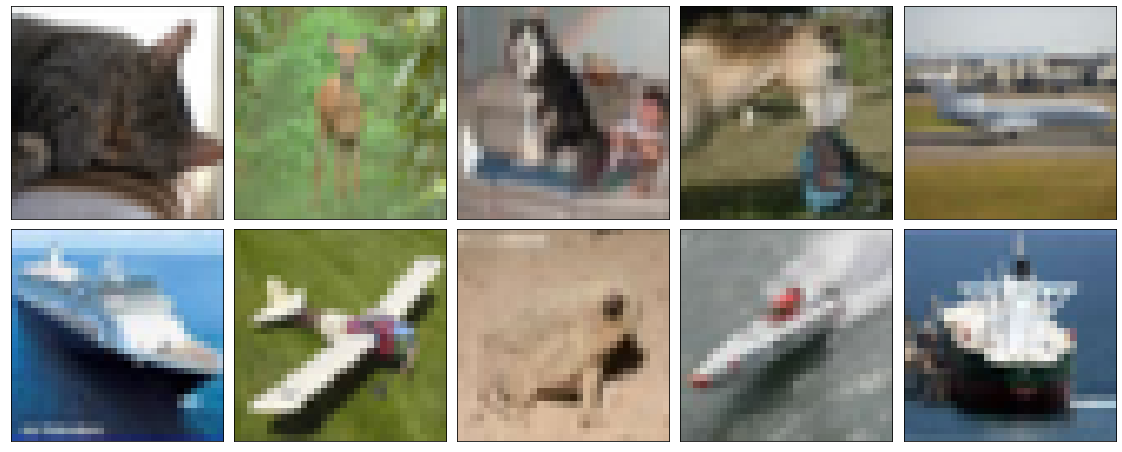

In [ ]:
#display images
plt.figure(figsize=(20,8))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.subplots_adjust(wspace=0,hspace=0.05)
  plt.imshow(sampled_x_train[i])
  plt.xticks([])
  plt.yticks([])
plt.savefig('cifar10')
plt.show()

9


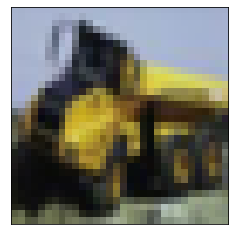

In [ ]:
#select image for CAM
test_image = sampled_x_train[69]
print(sampled_y_train[69])
plt.xticks([])
plt.yticks([])
plt.imshow(test_image)
plt.savefig('ex')

In [ ]:
#load trained models without distance loss
model = keras.models.load_model('/content/drive/MyDrive/cifar10experiment/1net/experiment/400_samples_seed_fix.h5')

tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


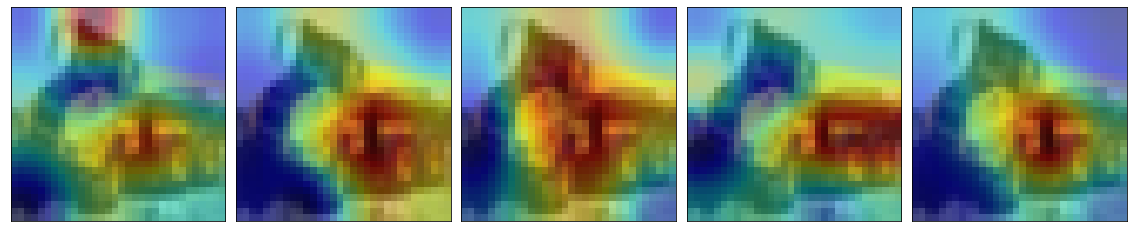

In [ ]:
#generate CAM for models without distance loss
plt.figure(figsize=(20,8))
for i in range(1,6):
  model_index = i
  mmm = keras.models.Model(inputs=model.layers[model_index].inputs,outputs=model.layers[model_index].output[0])
  print(tf.argmax(mmm(test_image.reshape(1,32,32,3))[0]))
  #mmm.layers[-1].activation = None
  heatmap = make_gradcam_heatmap(test_image.reshape(1,32,32,3),mmm,layer_index=23,pred_index=None)
  plt.subplot(1,5,i)
  plt.subplots_adjust(wspace=0.05,hspace=0.05)
  plt.imshow(test_image)
  plt.imshow(resize_images([heatmap], 32,32)[0], alpha=0.4, cmap='jet')
  plt.xticks([])
  plt.yticks([])
plt.savefig('ex_cifar10_VGG16')
plt.show()

In [ ]:
#load trained models with distance loss
model1 = keras.models.load_model('/content/drive/MyDrive/cifar10experiment/1net/64128256meanmask/100_samples_seed_fix_m1_m10.h5')

tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)


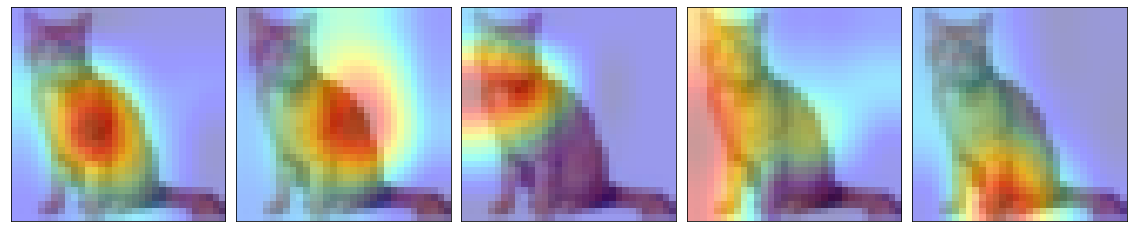

In [ ]:
#generate CAM for models with distance loss
plt.figure(figsize=(20,8))
for i in range(1,6):
  model_index = i
  mmm1 = keras.models.Model(inputs=model1.layers[model_index].inputs,outputs=model1.layers[model_index].output[0])
  print(tf.argmax(mmm1(test_image.reshape(1,32,32,3))[0]))
  #mmm.layers[-1].activation = None
  heatmap = make_gradcam_heatmap(test_image.reshape(1,32,32,3),mmm1,layer_index=23,pred_index=None)
  plt.subplot(1,5,i)
  plt.subplots_adjust(wspace=0.05,hspace=0.05)
  plt.imshow(test_image)
  plt.imshow(resize_images([heatmap], 32,32)[0], alpha=0.4, cmap='jet')
  plt.xticks([])
  plt.yticks([])
plt.savefig('ex_cifar10_VGG16_d')
plt.show()